# $\beta$ Variational Autoencoders to Disentangle Multi-channel Neural Timeseries  Data

In this notebook we first outline the motivation for applying autoencoders to neural timeseries, then we demonstrate how to use the `indl` library to implement variational sequential autoencoders to disentangle neural timeseries data, with extra attention spent on comparing different approaches to promote disentanglement.

## Autoencoders for Neural Data

Many more neurons modulate their activity during a set of behaviours than are strictly necessary for a minimal representation of those behaviours. (I'm using the term 'behaviour' very loosely here; it could equally apply to stimulus perception or movement.) Similarly, each neuron participates in many different behaviours, and it is sometimes difficult to predict how a neuron will modulate during a behaviour based on its modulation during other behaviours, or even other phases of the same behaviour; this is known as "mixed selectivity". These phenomena of redundancy and mixed selectivity necessitated a shift in neuroscience away from the "neuron doctrine" toward the "neural population doctrine" ([Saxena and Cunningham, Current Opinion in Neurobiology, 2019](https://doi.org/10.1016/j.conb.2019.02.002)). Neurons are highly correlated -- as one would expect due to their physical connections -- and the description of the correlation structure can similarly describe the population information coding capacity ([Kohn et al., Ann. Rev Neuro, 2016](https://doi.org/10.1146/annurev-neuro-070815-013851)). The unit of computation in the brain is not the single neuron but the ensemble of covarying neurons, and computation happens in a low-dimensional manifold within the neural population space ([Ruff et al., Ann. Review of Neuroscience, 2018](https://doi.org/10.1146/annurev-neuro-080317-061936)). Dimensionality reduction techniques have become increasingly important tools in our understanding of brain function ([Hurwitz et al., arXiv 2021](https://arxiv.org/abs/2102.01807), [Cunningham and Yu, Nature Neuroscience, 2014](https://www.nature.com/articles/nn.3776)), even motivating a recent [neural latents benchmark](https://neurallatents.github.io/).

Generally, the main goal of dimensionality reduction is to reduce high dimensional data into a lower dimensional representation that is more tractable and more intuitive. If the low-dimensional representation of neural data is semantically meaningful then it can help provide insight into what contextual information and stimulus parameters are important for computation in the brain. For example, in a stimulus-driven task, the latent variables driving the observed spiking data might represent upstream encoding of task-relevant features, and might facilitate understanding of learning processes when these features are assigned new meaning experimentally. Another less-informal goal of dimensionality reduction is that low-dimensional representations should "make it easier to extract useful information when building classifiers or other predictors" (Bengio et al., 2013), which could lead to better performing and more generalizable brain-computer interfaces (BCIs). The autoencoder model architecture has been applied to the problem of finding latent representations of neural data ([Pandarinath et al., LFADS](https://www.nature.com/articles/s41592-018-0109-9)) and denoising ([Altan et al., “Joint Autoencoder”, bioRxiv 2020](https://doi.org/10.1101/2020.12.17.423196)).

> I admit that the definition of variational autoencoders I provide in the following text is not very approachable. I really like [this description of VAEs by Joseph Rocca](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73). It has wonderful images, and it begins by orienting the reader from the perspective of dimensionality reduction like PCA, which is likely familiar to people who work with neural data. If you aren't already familiar with VAEs then please begin there. I chose the approach that I did because it will facilitate description of some of the more complicated models later.

Dimensionality reduction is often implemented as the solution to a generative model. We assume that observed high-dimensional neural data $x$ -- recorded with many electrodes -- is the result of a decoder process $d(z)$ driven by unobservable lower-dimensional latent variables $z$, sometimes called neural modes. If we treat the process as deterministic then we get $x = d(z)$.

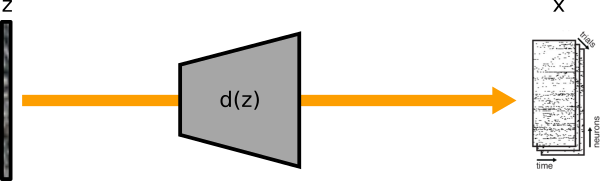

If the deterministic model has sufficient capacity (i.e., $d(z)$ has many parameters) then it can severely overfit the data and simply memorize the transformation from any latent value -- such as a trial index -- to the observation associated with that latent value. When this happens, the latent variable has no meaning and offers no insight. To help make the latent variables meaningful, a variational autoencoder (VAE) represents the latent variables as a multivariate distribution from which we draw samples to get the inputs to the decoder process, and the VAE training regularizes the latent distributions to help fill the latent space and make its dimensions more meaningful.

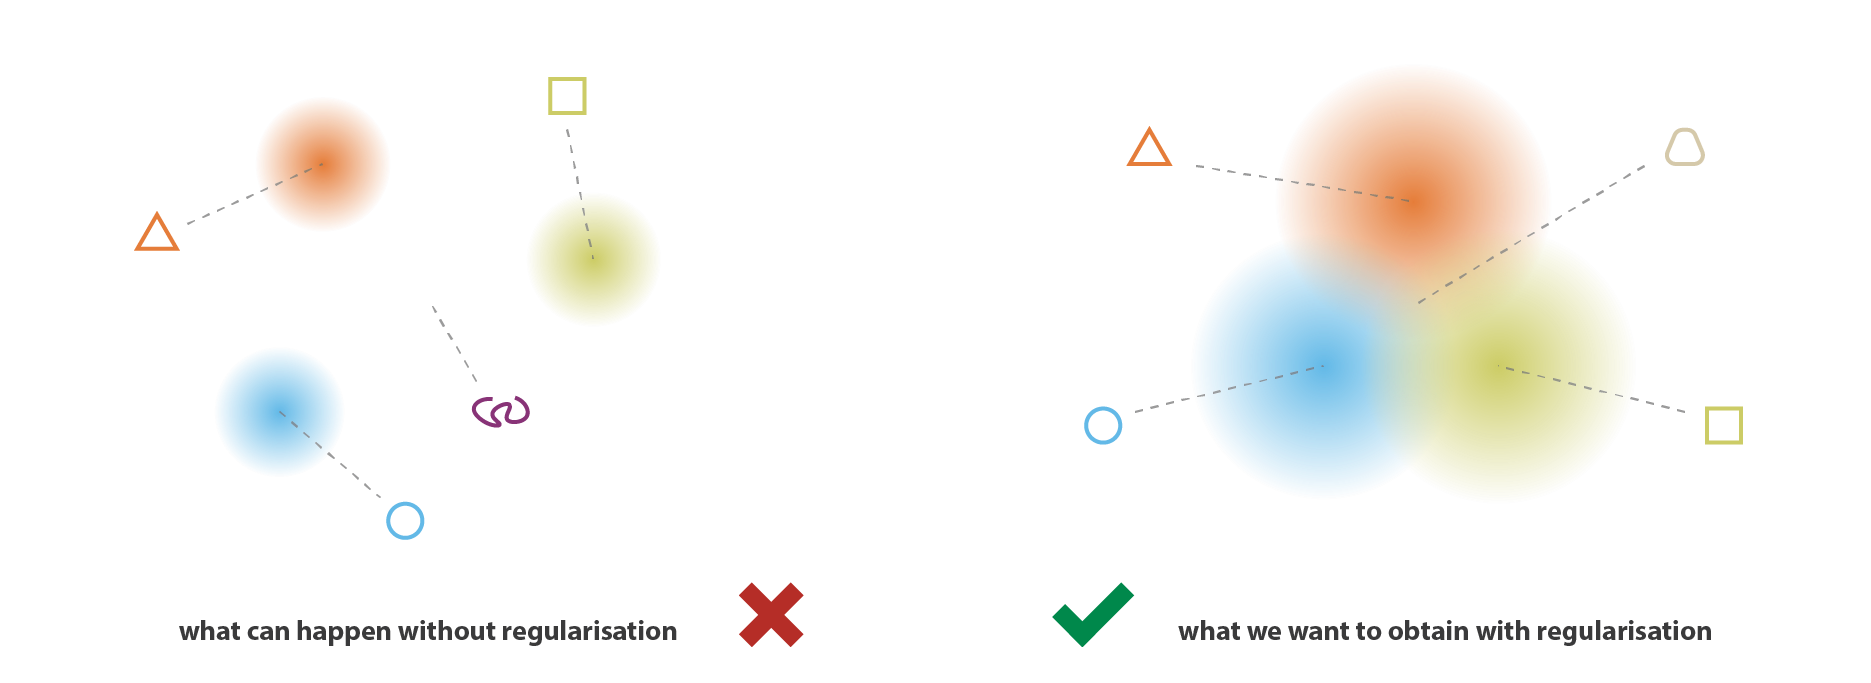
[From "Understanding VAEs" by Joseph Rocca.](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

We thus recast the decoder from deterministic to probabilistic. First, the latent representation $z$ is a sample from a prior distribution $p(z)$. Second, the output of the decoder is also probabilistic, defined by $p(x|z)$, from which a sample draw of x is likely. The model has the following structure:

$$
p(x,z) = p(x|z)p(z)
$$

That is, the joint distribution of the observed and latents is the product of the 'observed conditioned on the latents' and the latents themselves.

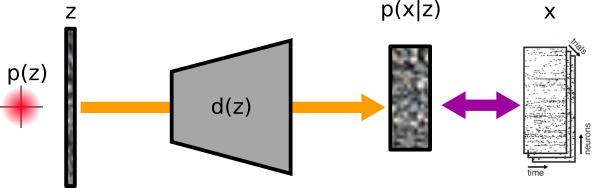


In practice, $z$ is usually sampled from an approximation $q(z)$. $q(z)$ is regularized to resemble the prior $p(z)$ which we can define to be anything, but typically we use a multivariate Gaussian with zero-mean with no covariance (i.e., the off-diagonal elements of the covariance matrix are all 0). Note that this is, in a way, a redefinition of $p(z)$ compared to above. Originally $p(z)$ was taken to mean a prior on the true latents; now $p(z)$ is a prior that we use to regularization the latent space.

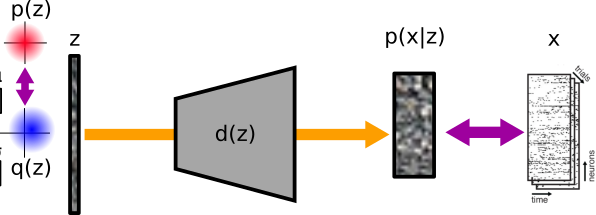

Recall that we are interested in understanding the latent variables $z$ in our data. So far we've described how $x$ can come from the variational approximation of $z$: $q(z)$, but we still don't have a way to get $q(z)$.

We can infer $z$'s distribution from the encoding process $e(x)$ to get $p(z|x)$. These distributions can be linked with Bayes' theorem:

$$
p( {z|x} ) = \frac{{p( {x|z} )p( z )}}{{p( x )}}\label{eqn:1}
$$

In practice, the output of the encoder $e(x)$ is the parameterization of the distribution. So in the case of a Gaussian this is its mean $\mu$ and standard deviation $\sigma$.
We approximate $p(z|x)$ with $q(z|x)$.

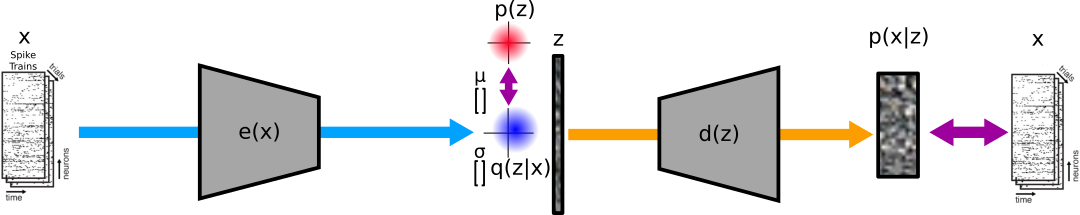

We use [variational inference](https://arxiv.org/pdf/1601.00670.pdf) to estimate the unknown distributions.

$$
\begin{align}
&\underset{e*,d*}{\mathrm{arg\,min}}(KL( {q(z|x)||p(z|x)})) \label{eqn:2} \\
=&\underset{e*,d*}{\mathrm{arg\,max}}({E_{q(z|x)}}\log p(x|z) - KL({q(z|x)||p(z)}))\label{eqn:3}
\end{align}
$$
That is, we find the parameterization of $e(x)$ and $d(z)$ that minimizes the KL-divergence between $q(z|x)$ and $p(z|x)$. The derivation is beyond the scope of this document, but this is equivalent to finding the parameterization that maximizes the log-likelihood of $p(x|z)$ and minimizes the KL divergence between $q(z|x)$ and $p(z)$. We use the negative of these two terms in the maximization problem, depicted as the pink double-ended arrows in the above figure, as our loss when training the model with gradient descent.

## Disentangling Autoencoder

We can control how much the KL-divergence contributes to the loss by a scaling factor $\beta$. And, when $p(z)$ is a Gaussian with mean 0, unit standard deviation, and no covariance, then we get

$\underset{e*,d*}{\mathrm{arg\,max}}({E_{q(z|x)}}\log p(x|z) - \beta KL({q(z|x)||N(0,1)}))\label{eqn:4}$

The $\beta$ parameter can be modified via a schedule during training. Initially it is zero or near zero to allow the reconstruction loss to dominate and not end up in a pathological state where all inputs lead to $N(0,1)$. Over epochs, $\beta$ is increased to regularize the latent space. This is known as a $\beta$-VAE ([Higgins et al., 2016](https://openreview.net/forum?id=Sy2fzU9gl)).

When the prior has diagonal covariance and $\beta$ is allowed to grow large, the latent dimensions are forced to be uncorrelated. In practice, forcing uncorrelated latent dimensions can often lead to the latent dimensions representing interpretable features that we would consider to be independent attributes. For example, in pictures of faces, gender is independent of hair colour is independent of darkness of glasses. When this happens, the latent dimensions are said to be **disentangled**. Indeed, a $\beta$-VAE is the most common and possibly the simplest form of a Disentangling Autoencoder.

> This concept of *disentangling* is distinct from *untangling* used by [Russo et al., Neuron 2018](https://www.sciencedirect.com/science/article/pii/S0896627318300072). The latter is specific to sequences, and has to do with the average derivative neural trajectories through latent space: if the trajectories that pass through a particular location in latent space have a consistent orientation then the average of their derivatives will have a large magnitude and be considered *untangled*. Conversely, if different trajectories traverse a common space with different orientations then the average derivative will be near zero, and this region is highly tangled. If a neural state is in untangled space then the path through that space is deterministic and robust to perturbations, as one might see in a neural trajectory from motor cortex executing a learned movement. Conversely, a neural state in a highly tangled space could be redirected easily by a small amount of noise, as one might see in a decision-making process when there is little evidence.

### Impossibility and Identifiability

$\beta$-VAEs and their extensions aim to disentangle the latent variables, but there is no guarantee that the inferred latent variables are the correct solution just because they are disentangled. Indeed, if the function from latent to observed variables is not linear then the problem is ill-posed, and one cannot recover the true independent latents from the observed variables alone.

Two related lines of research describe how unsupervised learning of disentangled representations is fundamentally impossible unless there is a strong inductive bias ([Locatello et al., 2020](https://arxiv.org/abs/2007.14184); [Locatello et al., 2019](https://arxiv.org/abs/1811.12359)), or the model is *identifiable* ([Khemakhem et al., arXiv 2020](https://arxiv.org/abs/1907.04809); [pwc](https://paperswithcode.com/paper/variational-autoencoders-and-nonlinear-ica-a)). Identifiability, an idea from nonlinear ICA, can occur when using a latent prior that has a factorized distribution that is conditioned on additionally observed variables, such as a class label, time index, previous data points in a time series, or almost any further observation, $u$. This family of models is called identifiable VIA (iVAE).

$$
p(x,z|u)=p_{d}(x|z)p(z|u)
$$

They make a few assumptions:
* the noise in $x$ is independent of $z$ or $d$.
* $p(z|u)$ is conditionally factorial, where each element of $z$ has a univariate (exponential family) distribution given conditioning variable $u$. Conditioning is through an arbitrary function $\lambda(u)$, such as a recurrent neural network.

As we will see, all of the disentangling sequential autoencoder models we will encounter implement a variation of this idea.

### Disentangling-(sequential)-VAEs in practice

Whether or not they were explicitly informed by the above studies, every disentangling-VAE variant I've encountered that is designed for sequence data has implemented a solution that factorizes the latent distribution conditioned on additional variables. The most trivial additional variable is the timestep, which conditions a low-dimensional time-varying latent (which we call $z_d$) to represent dynamic "content", while the more typical high-dimensional yet static latent (which we call $z_s$) is left to represent the "style". For example in a speech autoencoder, z_d would represent the words and z_s would represent something identifiable about the speaker. We have identified several different disentangling-VAE architectures that have taken this approach:

* [LFADS](https://github.com/snel-repo/lfads_tf1) ([Keshtkaran, ..., Pandarinath, 2021](https://www.biorxiv.org/content/10.1101/2021.01.13.426570v1))
* [DSAE](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/disentangled_vae.py) ([Li and Mandt, ICML 2018](https://arxiv.org/pdf/1803.02991.pdf)) - "Full" model.
* DSAE - "Factorized' model
* [FHVAE](https://github.com/wnhsu/ScalableFHVAE) ([Hsu and Glass](https://arxiv.org/pdf/1804.03201.pdf)).
* [FDMM](https://groups.csail.mit.edu/sls/publications/2019/SameerKhurana_ICASSP-2019.pdf), drived from FHVAE, models state transition probabilities in the prior.
* [iLQR-VAE](https://github.com/marineschimel/ilqr_vae) ([Schimel, ..., Hennequin, 2021](https://www.biorxiv.org/content/10.1101/2021.10.07.463540v1.full.pdf))

From these we identify a general abstraction of the disentangling-sequential-VAE (DSAE) architecture.

TODO: Image of general architecture

The below table provides the major differences between the models.

|              | LFADS                         | DSAE full                       | DSAE factorized | FHVAE                       | FDMM
| :---         | :---                          | :---                            | :---            | :---                        | :---
| $z_s$        | initial conditions            | f                               | f               | z2                          | y
| $z_d$        | controller input              | z                               | z               | z1                          | z
| $e_{z_s}$    | $BiGRU(x)$                    | BiLSTM(x)                       | ??              | LSTM->LSTM                  | $BiLSTM(x)$
| $e_{z_d}$    | A:$BiGRU(x)$, B:$GRU(A, z_d)$ | RNN(x, tile(z_d))               | $MLP(x_t)$      | LSTM((x, tile(z_d)))->LSTM  | A: Backward RNN, B: "combiner"
| $p(z_s)$     | $\mathcal{N}(0,\kappa I)$     | $\mathcal{N}(\mu_z,\sigma_zI)$  | ??              | $\mathcal{N}(\mu_2,0.5^2I)$ | ??
| $p(z_d)$     | LearnableAutoRegressive1Prior | LSTM(0)                         | ??              | $\mathcal{N}(0,I)$          | "gated transition"
| decoder      | Complex w/ GRU RNN            | CNN?                            | CNN?            | LSTM x2                     | Linear DNN
| RNN input0   | $0 / z1$                      | ??                              | ??              | concat(z_stat, z_dyn)       | ??
| RNN state0   | $z2$                          | ??                              | ??              | 0                           | ??
| RNN output   | -MLP-> fac -MLP-> rates       | ??                              | ??              | (x_mu, x_logvar)            | ??
| Decoder loss | -log(p spike\|Poisson(rates)) | ??                              | ??              | sparse sce with logits      | ??
| Learning rate| 1e-2 decay 0.95 every 6       | ??                              | ??              | ??                          | ??

There are additional differences in implementation details between the models, any of which can be used in any of the models. These include the optimizer, learning rate, where to insert dropout and how much, etc.

### Further improvements to $\beta$-VAE

Recent $\beta$-VAE extensions add augmentations that separate the KL-divergence between the latents and the latent-prior into `I(x;z) + KL(q(z)||p(z))`, where `I` is mutual information among inputs (x) and latents (z), and they penalize the KL term to promote disentangling without penalizing `I` which would harm reconstruction.

* **FactorVAE** [Kim and Mnih, 2018](https://paperswithcode.com/paper/disentangling-by-factorising)
    * No official repo for FactorVAE, but [here's one using TF2](https://github.com/elda27/FactorVAE)
* **$\beta$-TCVAE** [Chen et al., 2019](https://paperswithcode.com/paper/isolating-sources-of-disentanglement-in).
    * beta-TCVAE has an official repo using pytorch, but [here is one using TF2](https://github.com/julian-carpenter/beta-TCVAE) that is for some reason not in the *Papers With Code* list and has some extras.
* The *Challenging Common Assumptions in the Unsupervised Learning of Disentangled Representations* paper [Locatello et al., 2019](http://proceedings.mlr.press/v97/locatello19a.html) examines these and other advances to VAEs, and has TF1 code for these augmentations and metrics.

TODO:

* Also add one of their disentangling metrics.
* A repo comparing 5 different VAE losses using pytorch [here](https://github.com/YannDubs/disentangling-vae). Also has a really nice explanation of the different losses at the end of the README.
* Add SRU++ cell type
* Add a discriminator for real vs fake reconstructions when keeping dynamic latent constant but swapping static latent from another trial.
    * [Swapping Autoencoder for Deep Image Manipulation by Park et al., 2020](https://arxiv.org/pdf/2007.00653.pdf) with [pytorch implementation](https://github.com/rosinality/swapping-autoencoder-pytorch).

## Getting Started with DSAEs in `indl`

This `indl` library defines a series of model-builder functions. Each function takes `params`, a dictionary of hyperparameters, and `inputs` containing one or more Keras tensors, and each returns the model outputs and other intermediate variables that need to be tracked.

The model-builder functions are mostly defined in `indl.model.beta_vae`, and that module makes extensive use of other `indl` modules. The functions are designed to be modular such that they can be used to build different VAE implementations when provided with the correct parameterization.

## Hyperparameters

We separate our hyperparameters into non-tunable 'arguments' and tunable 'parameters'. This helps with the hyperparameter optimization framework. Both are defined at the top of `indl.model.beta_vae`.


In [1]:
import tensorflow as tf
from indl.model.beta_vae import generate_default_args, generate_default_params

_params = generate_default_params()
_args = generate_default_args()
j_params = {**_params, **_args.__dict__}

## Prepare inputs

The first step is to prepare the inputs for entry into the encoder(s).

This comprises several steps:

* dropout
* (optional) split off inputs to the f_encoder to prevent acausal modeling
* (optional) coordinated dropout
* (not implemented) CV mask
* (optional) Dense layer to read-in inputs to a common set of input factors.


In [4]:
from tensorflow.keras import backend as K
from indl.model.beta_vae import prepare_inputs

n_times = 246
n_sensors = 36

K.clear_session()
inputs = tf.keras.Input(shape=(n_times, n_sensors))
f_enc_inputs, z_enc_inputs, cd_mask = prepare_inputs(j_params, inputs)
print("inputs: ", inputs)
print("inputs to f-encoder: ", f_enc_inputs)
print("inputs to z-encoder: ", z_enc_inputs)
print("coordinated dropout mask: ", cd_mask)

inputs:  Tensor("input_1:0", shape=(None, 246, 36), dtype=float32)
inputs to f-encoder:  Tensor("coordinated_dropout/Identity:0", shape=(None, 246, 36), dtype=float32)
inputs to z-encoder:  Tensor("concat:0", shape=(None, 246, 36), dtype=float32)
coordinated dropout mask:  Tensor("coordinated_dropout/Identity_1:0", shape=(None, 246, 36), dtype=bool)


## *f*-Encoder

Transform full sequence of "features" (`inputs` or `ReadIn(inputs)`) through (1) RNN then (2) affine to yield parameters of latent posterior distribution:
$$q(f | x_{1:T})$$
This distribution is a multivariate normal, optionally with off-diagonal elements allowed.

In [5]:
from indl.model.beta_vae import create_f_encoder, make_f_variational

enc_f = create_f_encoder(j_params, f_enc_inputs)
q_f = make_f_variational(j_params, enc_f)
print("encoded f latents: ", enc_f)
print("q(f) - latents as distributions: ", q_f)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
encoded f latents:  Tensor("f_rnn_0/Identity:0", shape=(None, 256), dtype=float32)
q(f) - latents as distributions:  tfp.distributions.MultivariateNormalDiag("distribution_lambda_MultivariateNormalDiag", event_shape=[10], dtype=float32)


### *f*-Prior

Model loss will include the KL divergence between the q_f posterior and a prior. The prior is a learnable multivariate normal diagonal. The prior is initialized with a mean of 0 and a stddev of 0.1 but these are trainable by default. (In LFADS, only the mean is trainable).

In [7]:
from indl.model.beta_vae import create_f_prior

f_prior = create_f_prior(j_params)
# Use during training with:
# f_kl = tfd.kl_divergence(q_f, f_prior)
print("Prior on q(f): ", f_prior)

Prior on q(f):  tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[], event_shape=[10], dtype=float32)


## *z*-Encoder

$q(z_t | x_{1:T})$

I have also seen this called the "Dynamic Encoder", or in LFADS the "Controller Input" encoder.

The *z*-Encoder varies quite a bit between the different Disentangling/$\beta$ Variational Autoencoder implementations. Indeed, in some formulations it isn't used at all, such as the LFADS model without inferred controller input. Where it is used, in general:

* The inputs are the original data sequences ($x_t$).
* Unlike the *f*-encoder, here we output full sequences.
* The output sequences parameterize a multivariate normal distribution **at each timestep**, sometimes with constraints on the temporal evolution (e.g., RNN or AR(1)).
* The encoder itself has as its first layer
    * a RNN (LSTM, GRU), often bidirectional, or
    * a simple MLP as in the DSAE Factorized model
* If the first layer is an RNN then there is usually a second layer forward-only RNN.

### Extra Details - DSAE Full

* The inputs are concatenated with a tiled sample from $q(f)$.
* We've added a parameter to choose if $q(f)$ is concatenated on the inputs into the first or second RNN, though there isn't a precedent for concatenating on the second.

### Extra Details - LFADS

* Like its f-Encoder, the RNN cells are a GRU with clipping.
* The secondary RNN input is the output from the primary RNN concatenated with the **decoder RNN's previous step + transformed through the factor Dense layer**.

Because the LFADS secondary RNN is so complicated, it is integrated into the decoder RNN itself in a "complex cell". The complex cell includes the z2 cell, makes the z2 outputs variational in $q(z_t)$, samples $q(z_t)$ for the inputs to the generative RNN cell, passes the output of the generative RNN step through a Dense to-factors layer, and finally uses that output as one of the inputs to the z2 cell. If `params['gen_cell_type']` is `"Complex"`, then we assume that LFADS is being used and we skip the second RNN in `create_z_encoder`, and we skip making the latents variational in `make_z_variational`.


In [8]:
from indl.model.beta_vae import create_z_encoder, make_z_variational

# Note: For f_sample, you can pass in q_f dist itself, or pass q_f.sample(N_SAMPLES) or even q_f.mean()
#  The former will use the default `convert_to_tensor_fn` which uses params['q_f_samples'].
enc_z = create_z_encoder(j_params, z_enc_inputs, f_sample=q_f)
q_z = make_z_variational(j_params, enc_z)
print("encoded z: ", enc_z)
print("q(z|x_t): ", q_z)

encoded z:  Tensor("Reshape_5:0", shape=(None, 246, 16), dtype=float32)
q(z|x_t):  tfp.distributions.MultivariateNormalDiag("distribution_lambda_1_MultivariateNormalDiag", event_shape=[4], dtype=float32)


### Z Prior

Model loss will include the KL divergence between the q_z posterior and a prior.

There are several versions of the Z prior.

* DSAE Full: An LSTM with a low-ish hidden size. It is used to generate an output sequence with length equal to q_z timesteps dim. The output sequence is then used to parameterize a MVNDiag distribution of equal dimensionality to q_z. (Implementation note: LSTM is initialized with zero-state and zero-input for sample 0, but subsequent samples are drawn from the previous step's **dist**.)
* DSAE Factorized: I'm not sure, maybe the same as above?
* LFADS: Two options. First seems unused: MVNDiag with zero-mean and trainable var. Second: Learnable AR1 process.

In [ ]:
from indl.model.beta_vae import create_z_prior
# TODO!

## Generator (Decoder part 1)

$p(x_t | z_t, f)$

The generator takes in the encoded latents contributing to the inputs and/or initial state, and outputs full sequences.

The generator layer is typically an RNN, though in some applications (e.g. video) it can be a CNN.

The encoded latents comprise a single-timestep latent vector (*f*) and optionally a low-dimensional sequence ($z_t$). Note that these latents are distributions, and therefore must be sampled from to get the initial state and/or the inputs to the generative RNN.

The q_f sample and the q_z sample may be combined in different ways to become the generator inputs.

* In LFADS, the generator is in the "ComplexCell", which also includes the z2 cell and the . Therein, the q_f sample is used as the generator's initial state and the q_z sample is used as the inputs.
* In DVAE, the q_z sample is used as an input to the generator RNN. The q_f sample can either be used as the initial condition to the generator, or it can be tiled and concated with q_z.

The generative RNN outputs a sequence. The next step after the sequence is typically a Dense layer to transform into "factors". Because the LFADS ComplexCell includes this step, as is required so that the factors can be fed-back to the z2_encoder step-by-step, we also include the Dense layer in our generator for easier interoperability.

In [ ]:
factors = create_generator(f_sample, z_sample)

## Probabilistic Reconstructed Input (Decoder part 2)

The factors are passed through a Dense layer and the outputs are the same dimensionality as the inputs, but instead of reconstructing the inputs, they parameterize a distribution representing the inputs. This distribution can be Gaussian or Poisson, with the latter being more appropriate for (binned) spike counts.